In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# <div class=consignes>Deep Learning et traitement du signal TP 1 </div>
<div class=consignes> L'objectif de ce TP est de prendre en main les outils de modélisation et d'analyse du signal présentés dans le premier cours et d'introduire la problématique de <it>détection</it> dont on parlera dans le cours numéro 3 </div>
<div class=consignes>Deadline de rendu : 15 octobre 2025, 13h59, par mail à deepetsignal.mva@gmail.com <br> Effort estimé : 2 à 3 heures maximum</div>
<div class=consignes>Le rendu de ce TP n'est pas obligatoire. Il permet d'obtenir un bonus de 1 (minimum syndical) à 3 (votre notebook servira de correction l'an prochain) points sur la moyenne des TP </div>

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp1.ipynb </div>

<div class=consignes>Si vous installez des paquets supplémentaires, merci de les lister dans la cellule suivante avec la syntaxe
    
```
!pip install \< nom_du_paquet \>
```
    
</div>

In [2]:
import numpy as np 
import matplotlib.pylab as plt 
import scipy
import IPython.display as ipd

## <div class=consignes>Partie 1: Audio </div>

### <div class=consignes>Visualisation</div>

 <div class=consignes>Enregistrez un fichier wav de quelques secondes de votre voix. 
  <br>
 Importez le avec scipy.io.wavfile.read et écoutez le dans le notebook avec IPython.display.Audio
</div>

In [3]:
sampling_frequency, amplitude = scipy.io.wavfile.read(r"coloniedefourmies.wav")
ipd.Audio(  data = amplitude,
            rate = sampling_frequency)


<div class=consignes>Visualisez la forme d'onde temporelle de ce signal audio. <br>
Estimez et affichez sa Densité Spectrale de Puissance. <br>
Donnez une interprétation de ce que vous observez. 
    </div>

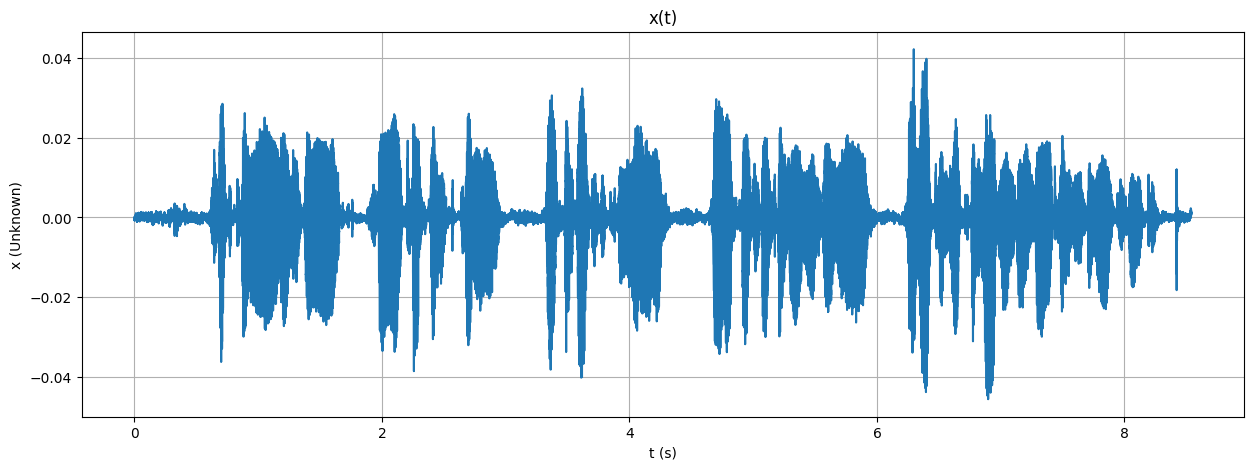

In [4]:
time = np.array([0 + i/sampling_frequency for i in range(len(amplitude))])
plt.figure(figsize = (15, 5))
plt.plot(time, amplitude)
plt.title('x(t)')
plt.xlabel('t (s)')
plt.ylabel('x (Unknown)')
plt.grid()
plt.show()

<div class=consignes> Calculez et affichez le spectrogramme du signal. <br>
Justifiez du choix des réglages que vous avez faits. <br>
Sélectionnez une portion pertinente du spectrogramme pour estimer visuellement le pitch de votre voix.
    </div>

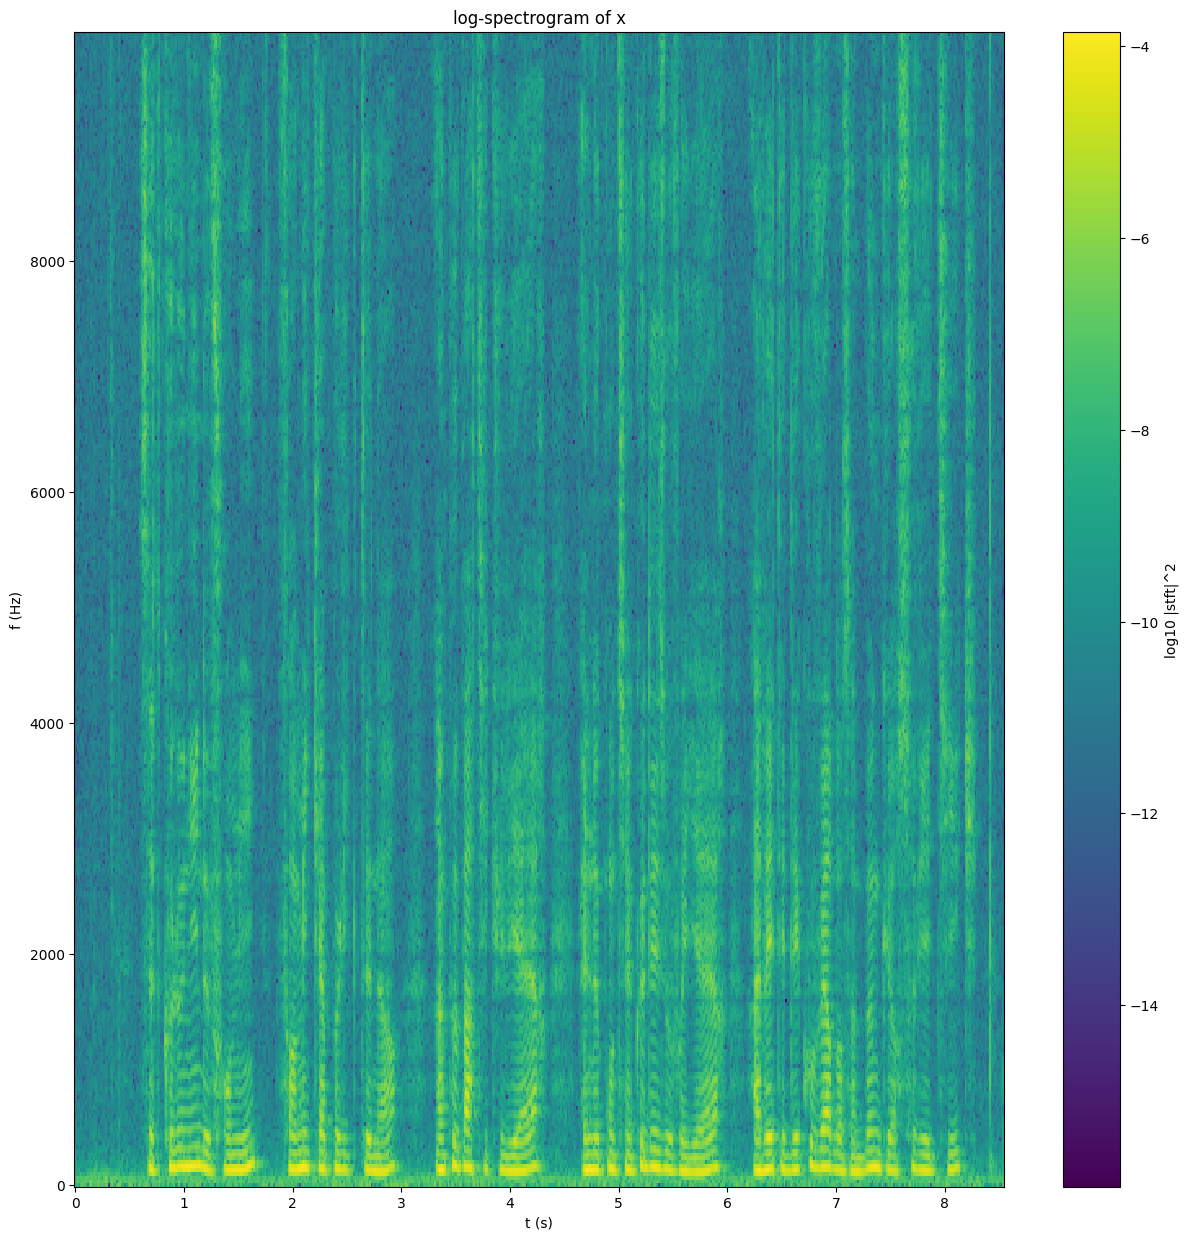

In [5]:

# Select the window size using time rather than number of points to preserve physical intuition
window_time_size = 0.03
window_sample_size = sampling_frequency*window_time_size

frequencies, time, short_time_fourier_transform = scipy.signal.stft(    amplitude,
                                                                        fs = sampling_frequency,
                                                                        nperseg = window_sample_size,
                                                                        nfft = window_sample_size)

# The spectrogram is defined as the squared module of the short time fourier transform
spectrogram = np.abs(short_time_fourier_transform)**2

# Unusual values above 12500 Hz (optionnal cut)
# Moreover, the human ear tends to cut frequenies above 10kHz so we know that the values above this limit are not likely to be pertinent for processing
# audible noise
frequency_upper_bound = 10000

frequencies = frequencies[frequencies<frequency_upper_bound]
spectrogram = spectrogram[:len(frequencies),:]

# The contrast is low at linear scale so we compensate by composing by log10
log_spectrogram = np.log10(spectrogram)

plt.figure(figsize = (15, 15))                  # Better to have a bigger height than risk loosing info by cutting at a frequency that is too low
plt.pcolor(time, frequencies, log_spectrogram)
plt.title('log-spectrogram of x')
plt.xlabel('t (s)')
plt.ylabel('f (Hz)')
plt.colorbar(label = 'log10 |stft|^2')
plt.show()




### <div class=consignes>Calcul du Pitch</div>

<div class=consignes>Proposez une méthode simple pour estimer automatiquement le Pitch de votre voix (cette méthode ne doit pas faire intervenir d'implémentations externes).

Utilisez cette méthode pour estimer les variations du Pitch le long du signal, estimez le pitch toutes les 20 ms et présentez vos résultats sous forme visuelle. 

Ne pas utiliser de méthode "toute faite" que vous pourriez par exemple trouver dans la bibliothèque librosa.

Commentez vos résultats.
    </div>

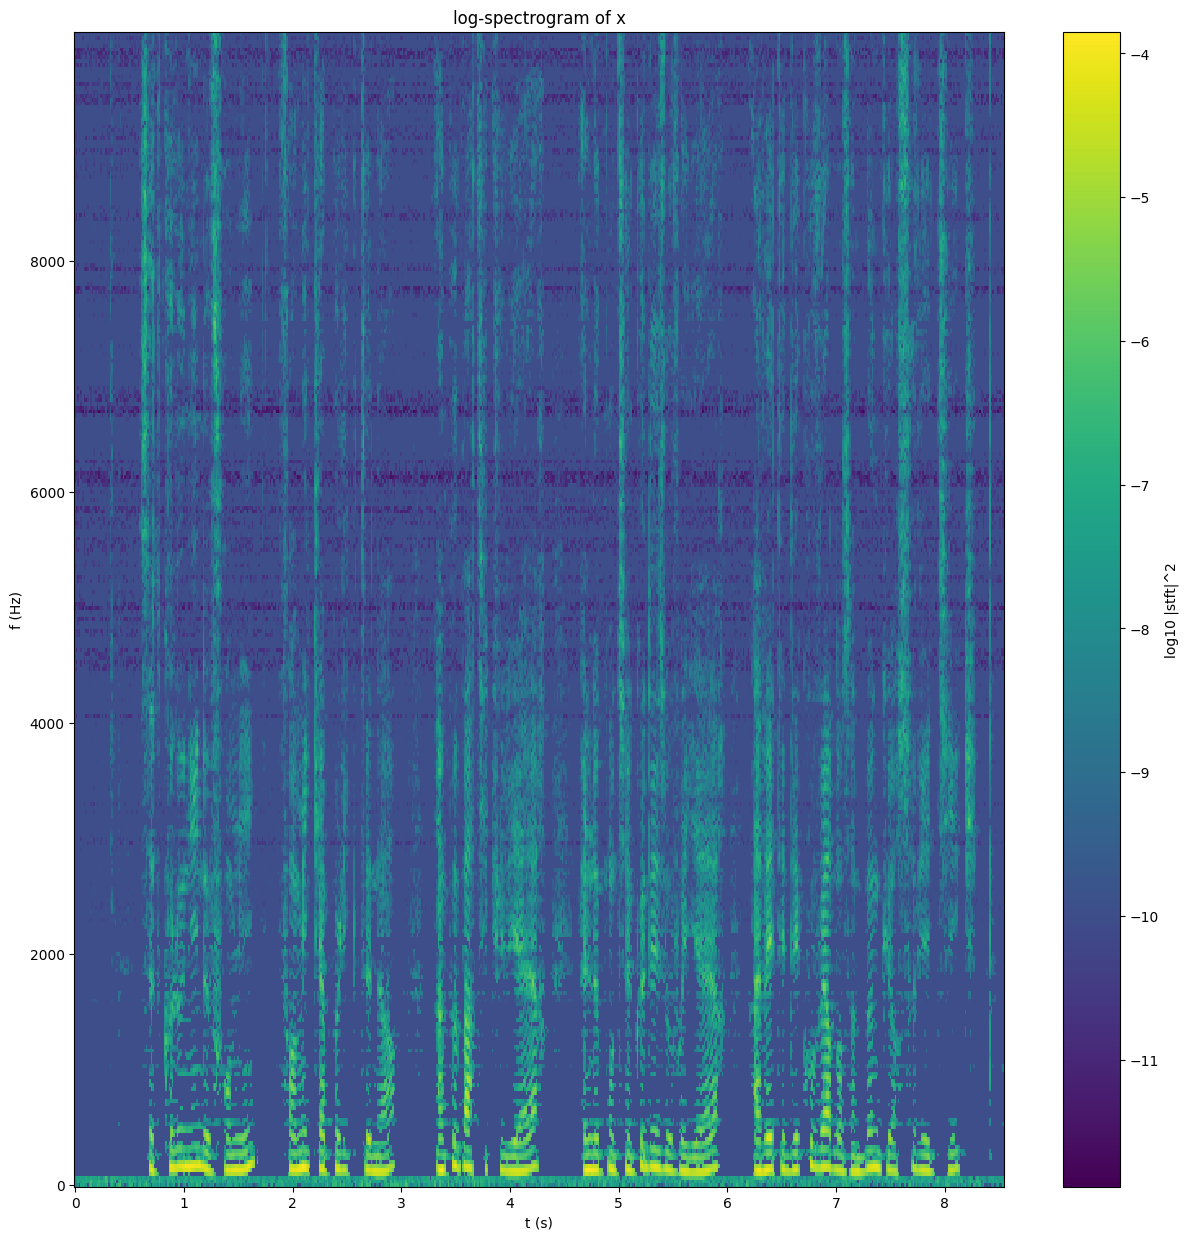

In [21]:
# Test : the pitch is supposed to cary the most power
# -> Does not work in practice ( due to unusual values from the mean of measure ??)
# May be usefull to check for harmonic first and then get the harmonic that carries the most power (i.e the lowest one)

tolerance = 0.5
max_log_DSP_windowize = np.max(log_spectrogram,
                               axis = 1)

# print(log_spectrogram.shape)
# print(max_log_DSP_windowize.shape)
max_log_DSP_windowize = np.transpose(np.array([max_log_DSP_windowize for i in range(log_spectrogram.shape[1])]))
# print(max_log_DSP_windowize.shape)

filtered_log_spectrogram = log_spectrogram.copy()
# print(max_log_DSP_windowize)
# print(filtered_log_spectrogram<=(max_log_DSP_windowize - tolerance))
# print(max_log_DSP_windowize - tolerance*max_log_DSP_windowize)

filtered_log_spectrogram[filtered_log_spectrogram<(max_log_DSP_windowize + tolerance*max_log_DSP_windowize)] = -10

plt.figure(figsize = (15, 15))                  # Better to have a bigger height than risk loosing info by cutting at a frequency that is too low
plt.pcolor(time, frequencies, filtered_log_spectrogram)
plt.title('log-spectrogram of x')
plt.xlabel('t (s)')
plt.ylabel('f (Hz)')
plt.colorbar(label = 'log10 |stft|^2')
plt.show()


[[1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


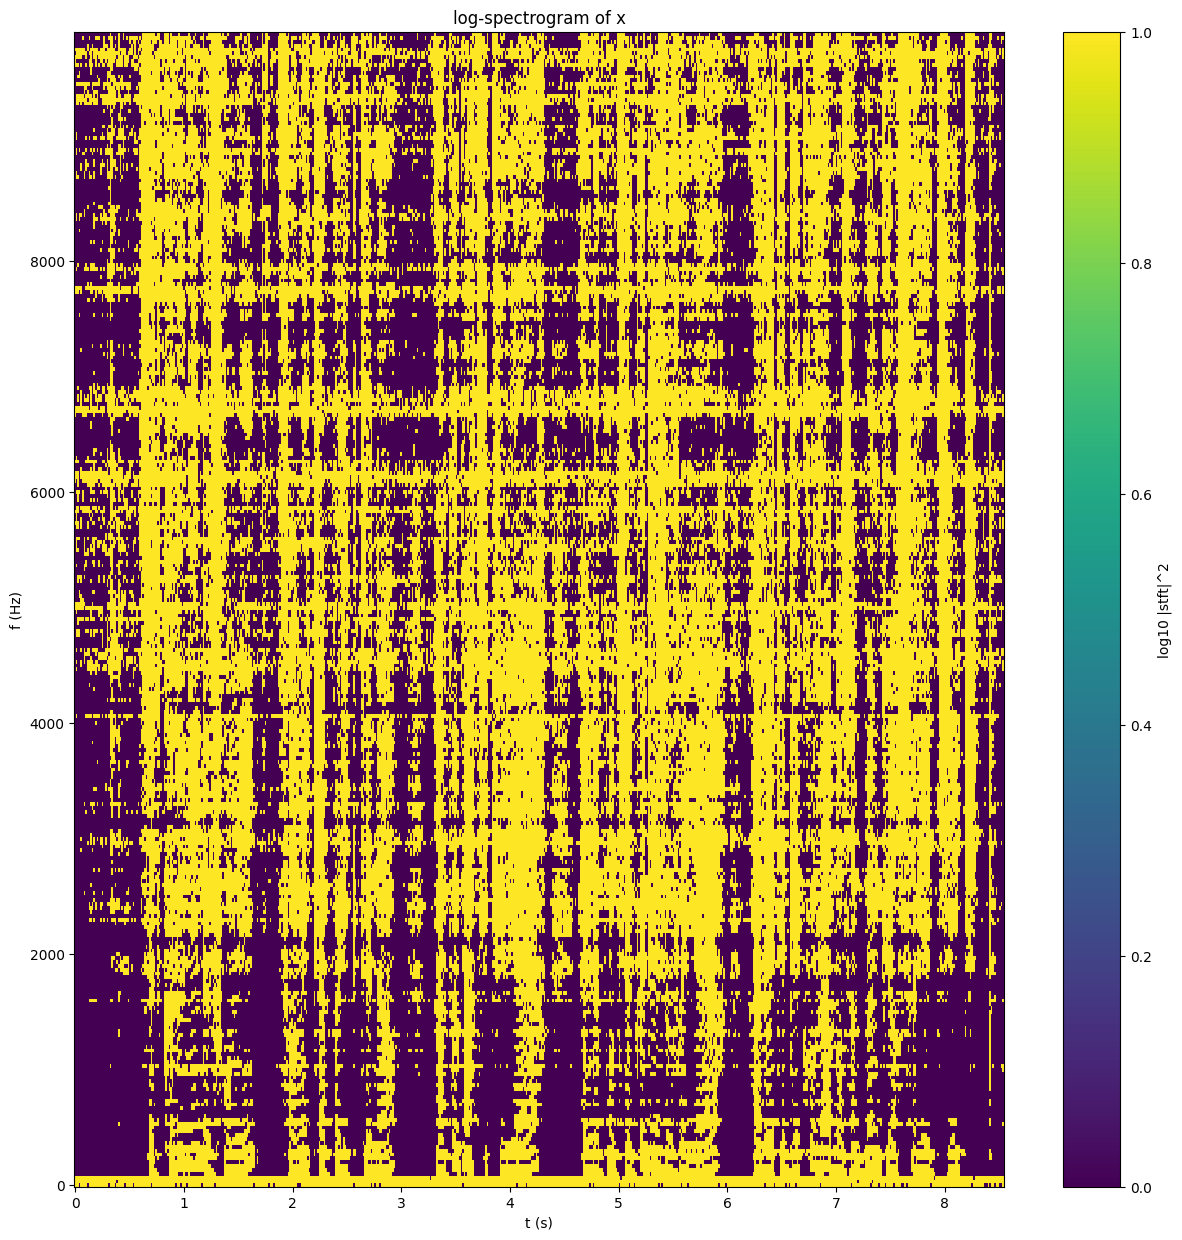

In [22]:
frequency_in_max_spd = log_spectrogram.copy()
frequency_in_max_spd[frequency_in_max_spd<(max_log_DSP_windowize + tolerance*max_log_DSP_windowize)]     = 0
frequency_in_max_spd[~(frequency_in_max_spd==0)]  = 1
print(frequency_in_max_spd)

plt.figure(figsize = (15, 15))                  # Better to have a bigger height than risk loosing info by cutting at a frequency that is too low
plt.pcolor(time, frequencies, frequency_in_max_spd)
plt.title('log-spectrogram of x')
plt.xlabel('t (s)')
plt.ylabel('f (Hz)')
plt.colorbar(label = 'log10 |stft|^2')
plt.show()

(300, 570)
(300,)
(570,)


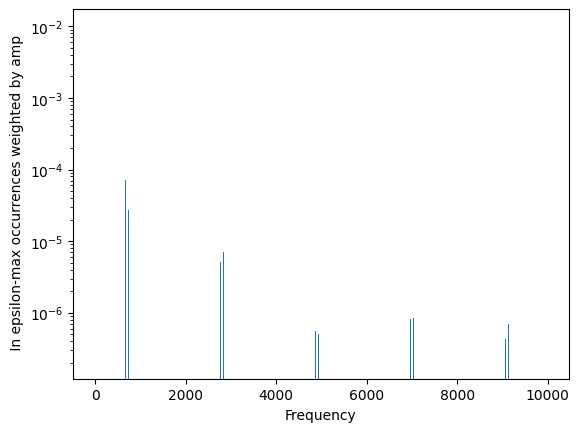

In [ ]:
in_max_count = np.zeros(len(frequencies))
print(frequency_in_max_spd.shape)
print(frequencies.shape)
print(time.shape)

amp_weight = 1

for time_step in range(len(time)):
    # in_max_count += frequency_in_max_spd[:,time_step] * amp_weight * log_spectrogram[:,time_step]
    in_max_count += frequency_in_max_spd[:,time_step] * amp_weight * spectrogram[:,time_step]

plt.bar(frequencies, in_max_count, width=0.8, align='center')
plt.xlabel("Frequency (Hz)")
plt.ylabel(" In epsilon-max occurrences weighted by amp")
plt.yscale('log')
plt.show()

In [34]:
pitch_index = list(in_max_count).index(max(in_max_count))
pitch = frequencies[pitch_index]
pitch

np.float64(133.33333333333334)

## <div class=consignes>Partie 2: Détection d'impulsion </div>

<div class=consignes> Un signal de durée 1 seconde et échantillonné à 1000 Hz est composé d'un bruit blanc gaussien de puissance inconnue et éventuellement d'une impulsion à une fréquence f0 comprise entre 100 et 200 Hz. 
<br><br>
Une série de 1000 signaux est enregistrée dans le fichier signaux_impulsions.npz. 
Ouvez ce fichier avec numpy (cf code plus bas). Le fichier contient une tableau signaux 10000 x 1000 dont chaque ligne contient un signal de durée 1000. Le fichiez contient aussi un tableau labels de taille 10000 dont la ligne i est à TRUE si le signal i contient une impulsion et à 0 sinon. 

</div>

In [8]:
donnees = np.load('signaux_impulsions.npz')
signaux = donnees['signaux']
labels = donnees['labels']

KeyError: 'signaux is not a file in the archive'

## <div class=consignes> Première méthode </div>

<div class=consignes> Proposez une méthode simple  pour décider si un signal contient une impulsion ou non à partir du calcul de l'énergie du signal. Cette méthode fera intervenir un seuil: 
</div>

```python
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
```

<div class=consignes>
Utilisez votre méthode avec un seuil fixé sur tous les signaux pour prédire s'ils contiennent une impulsion ou non. 
</div>

<div class=consignes>
Calculez: <br>
- VP = le nombre de signaux que vous détectez comme contenant une impulsion qui contiennet effectivement une impulsion <br>
- FP = le nombre de signaux que vous détectez comme contenant une impulsion qui ne contiennet en fait PAS une impulsion <br>
- VN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion qui ne contiennet effectivement PAS une impulsion<br>
- FN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion mais qui  contiennet en fait une impulsion
</div>

## <div class=consignes>Deuxième méthode </div>

<div class=consignes>Proposez une deuxième méthode faisant par exemple intervenir le spectrogramme du signal. Cette méthode fera encore intervenir un seuil
</div>

```python
def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
```


<div class=consignes> Calculez pour cette nouvelle méthode, pour un certain seuil les valeurs de VP, FP, VN, FN </div>

## <div class=consignes> Comparaison des méthodes </sdivs>

<div class=consignes>Pour une méthode de détection et un seuil donné, la précision est définie comme: 
$$ \frac{\sharp\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{\sharp\text{Signaux détectés comme positifs }}$$
et le rappel comme:
$$ \frac{\sharp\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{\sharp \text{Signaux contenant une impulsions}} $$
    
</div>

<div class=consignes> Donnez une interprétation de ces deux métriques </div>

<div class=consignes>
    Pour chacune des deux méthodes proposées, faites varier le seuil sur une dizaine de valeurs et calculez la précision et le rappel pour chacun de ces seuils. 

Affichez dans le plan (précision , rappel) les points de fonctionnement des deux méthodes pour différents seuils. <br>Commentez le résultat. 
    </div>